In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geoutils as gu
import geopandas as gpd
import pandas as pd
from scipy.interpolate import RegularGridInterpolator

In [5]:
ds = xr.load_dataset("./data/velocity_Radar_2026.nc")
#ds = xr.load_dataset("./data/Hubbard_S1.nc")
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["v_smooth"] = ds["v"].rolling(time=5, center=True).mean()
ds["v_grad"] = ds.v_smooth.differentiate("time")
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear

monthly_mean = ds["v"].resample(time="M").mean()

ds = ds.resample(time="M").mean()

/Users/amyjenson/miniconda3/envs/itslive/lib/python3.10/site-packages/xarray/groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/Users/amyjenson/miniconda3/envs/itslive/lib/python3.10/site-packages/xarray/groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


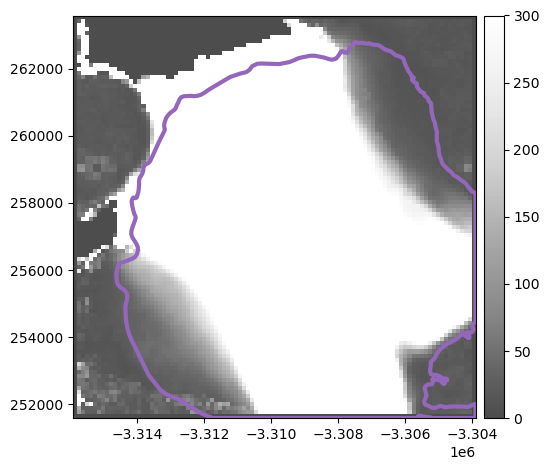

In [8]:
# Make a template Raster object representing the glacier

# Pixel size (assuming uniform spacing)
dx = float(ds.x[1] - ds.x[0])
dy = float(ds.y[1] - ds.y[0])

# Origin (top-left corner)
x0 = float(ds.x[0])
y0 = float(ds.y[0])

# Construct transform: (a, b, c, d, e, f)
# b = d = 0 for axis-aligned
# e = negative if y decreases downward (typical raster)
transform = (dx, 0.0, x0, 0.0, dy, y0)

template = gu.Raster.from_array(np.nanmean(monthly_mean.values, axis = 0), transform, 3413)


# Load RGI data
import shapely
RGI = gpd.read_file('./data/RGI_outlines/RGI2000-v7.0-G-01_alaska.shp').to_crs('4326')
RGI = RGI[(RGI['rgi_id'] == "RGI2000-v7.0-G-01-15252") | (RGI['rgi_id'] == 'RGI2000-v7.0-G-01-15351')]
RGI = shapely.ops.unary_union(RGI.geometry)
RGI = gu.Vector(RGI).set_crs(4326).to_crs(template.crs)

RGI = RGI.crop(template, clip=True)
template.plot(ax="new", cmap="Greys_r", alpha=0.7, vmax = 300)
RGI.plot(ref_crs=template, fc="none", ec="tab:purple", lw=3)

# Convert vector to raster
RGI_raster = RGI.rasterize(template)

# Create array where off-ice pixels are NaNs
mask_ice = np.full(RGI_raster.data.data.shape, np.nan)
mask_ice[RGI_raster.data.data==1] = 1

# Set to NaN every slice
ds["v"] = ds["v"] * mask_ice[np.newaxis,:]
ds["vx"] = ds["vx"] * mask_ice[np.newaxis,:]
ds["vy"] = ds["vy"] * mask_ice[np.newaxis,:]
ds["v_smooth"] = ds["v_smooth"] * mask_ice[np.newaxis,:]

# Create filter for unrealistic values
thr = ds["v"].quantile(0.9999, dim=("time", "y", "x"), skipna=True)
ds["v"] = ds["v"].where(ds["v"] <= thr)
ds["vx"] = ds["vx"].where(ds["vx"] <= thr)
ds["vy"] = ds["vy"].where(ds["vy"] <= thr)
ds["v_smooth"] = ds["v_smooth"].where(ds["v_smooth"] <= thr)

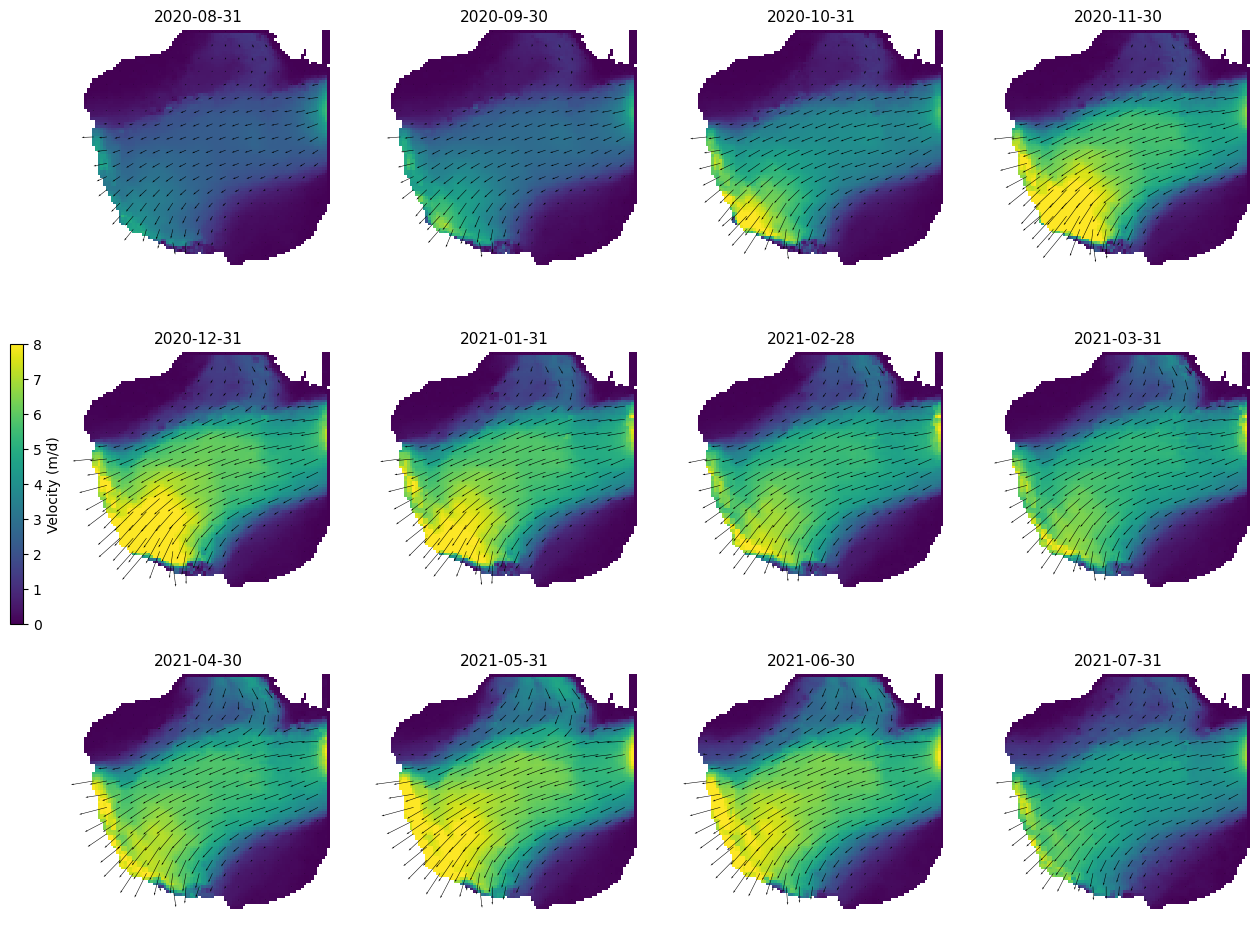

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Coordinates and time
x = ds["x"].values
y = ds["y"].values
time = pd.to_datetime(ds["time"].values)

# --- Select August 2020 to August 2021 ---
start_date = pd.Timestamp('2020-08-01')
end_date = pd.Timestamp('2021-08-31')
date_mask = (time >= start_date) & (time <= end_date)

vv_period = ds["v_smooth"].values[date_mask]
vx_period = ds["vx"].values[date_mask]
vy_period = ds["vy"].values[date_mask]
time_period = time[date_mask]

X, Y = np.meshgrid(x, y)

# --- Figure layout ---
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(
    nrows=3, ncols=5,
    width_ratios=[0.05, 1, 1, 1, 1],
    hspace=0.15, wspace=0.2
)

axes = np.empty((3, 4), dtype=object)
for i in range(3):
    for j in range(4):
        axes[i, j] = fig.add_subplot(gs[i, j+1])

# Shared color limits
vmin = 0
vmax = 8
qm = None

# --- Plot monthly panels ---
for k in range(12):
    i, j = divmod(k, 4)
    ax = axes[i, j]
    
    # Rotate arrays 90° clockwise (k=1)
    vv_rot = np.rot90(vv_period[k], k=1)
    vx_rot = np.rot90(vx_period[k], k=1)
    vy_rot = np.rot90(vy_period[k], k=1)
    
    # **CORRECTED: Rotate velocity vectors**
    # 90° clockwise rotation: (x, y) -> (y, -x)
    U = -vy_rot.copy()
    V = vx_rot.copy()
    
    # Scalar field
    qm = ax.pcolormesh(
        X, Y, vv_rot/365.25,
        shading="auto", vmin=vmin, vmax=vmax, cmap="viridis"
    )
    
    # Mask quiver outside valid data
    mask = np.isnan(vv_rot)
    U[mask] = np.nan
    V[mask] = np.nan
    
    step = 5
    ax.quiver(
        X[::step, ::step], Y[::step, ::step],
        U[::step, ::step], V[::step, ::step],
        color="k", scale=30000, width=0.002
    )
    
    # Title as dd-mm-yyyy
    ax.set_title(time_period[k].strftime("%Y-%m-%d"), fontsize=11)
    
    # Remove spines, ticks, labels
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# --- Single colorbar left of middle row ---
cax = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(qm, cax=cax)
cb.set_label("Velocity (m/d)")

# Aspect ratio
for ax in axes.flat:
    ax.set_aspect("equal")

plt.show()


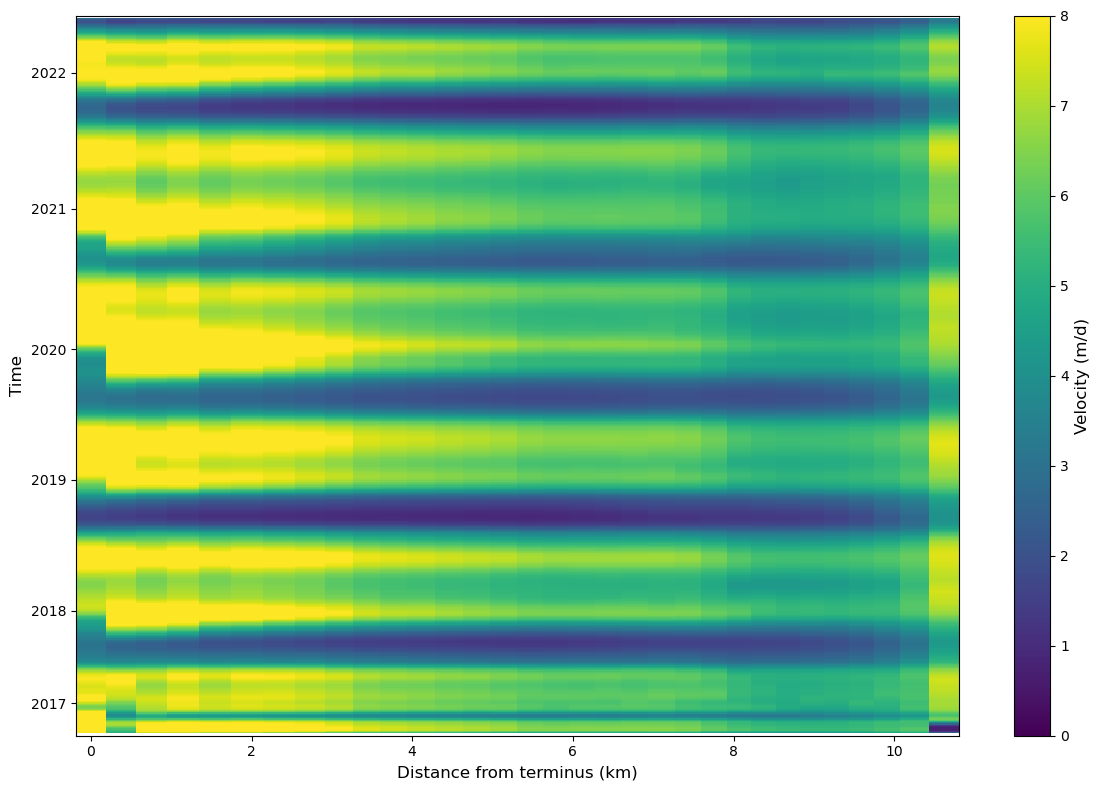

In [11]:
# Load the flowline where we extract the velocities
flowline = pd.read_csv('./data/flowline_5.csv')

# Load the velocity dataset
#ds = xr.load_dataset("./data/Hubbard_S1.nc")
ds = xr.load_dataset("./data/velocity_Radar_2026.nc")
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["v_smooth"] = ds["v"].rolling(time=5, center=True).mean()
ds["v_grad"] = ds.v_smooth.differentiate("time")
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear

# Get coordinates from dataset
x = ds["x"].values
y = ds["y"].values
time = pd.to_datetime(ds["time"].values)

# Automatically select min and max dates
start_date = time.min()
end_date = time.max()
date_mask = (time >= start_date) & (time <= end_date)

vv_period = ds["v_smooth"].values[date_mask]
time_period = time[date_mask]

# Calculate distance along flowline
flowline_x = flowline['x'].values
flowline_y = flowline['y'].values
dx = np.diff(flowline_x)
dy = np.diff(flowline_y)
distances = np.concatenate([[0], np.cumsum(np.sqrt(dx**2 + dy**2))])

# Calculate distance from terminus (last point)
distances_from_terminus = distances[-1] - distances

# Extract velocity along flowline for each time step
n_times = len(time_period)
n_points = len(flowline)
velocity_profile = np.zeros((n_times, n_points))

for t in range(n_times):
    # Create interpolator for this time step
    interp = RegularGridInterpolator((y, x), vv_period[t], 
                                      bounds_error=False, fill_value=np.nan)
    
    # Extract values at flowline points
    points = np.column_stack([flowline_y, flowline_x])
    velocity_profile[t, :] = interp(points)

# Find columns (flowline points) that are not all NaN
valid_cols = ~np.all(np.isnan(velocity_profile), axis=0)
velocity_profile_filtered = velocity_profile[:, valid_cols]
distances_filtered = distances_from_terminus[valid_cols]

# Convert distances to km
distances_km = distances_filtered / 1000

# Create Hovmöller plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot
im = ax.pcolormesh(distances_km, np.arange(n_times), velocity_profile_filtered / 365.25,
                   shading='auto', cmap='viridis', vmin=0, vmax=8)

# Formatting
ax.set_xlabel('Distance from terminus (km)', fontsize=12)
ax.set_ylabel('Time', fontsize=12)

# Find closest date to January 1st for each year
years = sorted(set(time_period.year))
jan1_indices = []
for year in years:
    target_date = pd.Timestamp(f'{year}-01-01')
    # Find closest date to Jan 1st of this year
    time_diff = np.abs(time_period - target_date)
    closest_idx = np.argmin(time_diff)
    jan1_indices.append(closest_idx)

ax.set_yticks(jan1_indices)
ax.set_yticklabels([str(year) for year in years])

#ax.set_title('Hovmöller Diagram: Velocity along Flowline', fontsize=14)

# Remove first 2 y-ticks
ax.set_yticks(jan1_indices[2:])
ax.set_yticklabels([str(year) for year in years[2:]])


# Colorbar
cb = plt.colorbar(im, ax=ax)
cb.set_label('Velocity (m/d)', fontsize=12)

plt.tight_layout()
plt.show()